# Implicit feedback datasets to look at

- https://www.kaggle.com/c/expedia-hotel-recommendations/data?select=train.csv
- https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations
- https://www.kaggle.com/CooperUnion/anime-recommendations-database
- https://www.kaggle.com/teesoong/ml-challenge?select=checkins.csv
- https://www.kaggle.com/minnieliang/rec-system
- https://www.kaggle.com/sohelranaccselab/goodreads-book-reviews
- https://www.kaggle.com/retailrocket/ecommerce-dataset?select=events.csv
- https://snap.stanford.edu/data/web-Amazon.html / http://jmcauley.ucsd.edu/data/amazon/links.html / https://nijianmo.github.io/amazon/index.html#subsets
- https://cseweb.ucsd.edu/~jmcauley/datasets.html#behance (Behance, implicit for real, very good)
- https://tianchi.aliyun.com/dataset/dataDetail?dataId=46 (seems good)
- https://dl.acm.org/doi/10.1145/2684822.2685322 (app recommendation, maybe this is what Derek suggested, but its not available)

# BPR
Assume an inderlying recommender, parameterized by $\Theta$, that models, for each user $u \in U$, the relevance of all the items $i \in I$. Denote $x_{ui}$ the relevance score of item $i$ to user $u$. Then, $x_{uij}(\Theta) = x_{ui}(\Theta) - x_{uj}(\Theta)$ models how much user $u$ prefers item $i$ over $j$. Given a user $u$ and a pair of items $(i, j)$, the probability that the user $u$ will prefer item $i$ over $j$ can be modeled as

$$
    P(i >_u j | \Theta) = \sigma(x_{uij}(\Theta)),
$$

For notation facility, the conditionality on $\Theta$ can be ommited. Assume that the preferences of each user are independent, and that the preference relation over each pair of items for each user are also independent. Then, Considering $u^+$ to be the set of items which user $u$ provided positive feedback about, the likelihood of all the users preferences for the training data is

$$
    L(>|\Theta) = \prod_{u \in U} P(>_u | \Theta) = \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} P(i >_u j | \Theta) 
$$

To complete the Bayesian framework, it is assumed, a priori, that $\Theta \sim N(0, \lambda I)$, where $\lambda$ controls the model complexity. The posterior distribution of the underlying recommender parameters for some user $u$ is

$$
    P(\Theta | >_u) \propto P(>_u | \Theta) P(\Theta)
$$

The optimal $\Theta^*$ is then choosen to maximize the log-likelihood of the posteriori distribution for $\Theta$.

\begin{align}
    \Theta^* &= \arg_\Theta\max \log P(\Theta | >_u) \\
             &= \arg_\Theta\max \log P(>_u | \Theta) P(\Theta) \\
             &= \arg_\Theta\max \log \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} \sigma(x_{uij}) P(\Theta) \\
             &= \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) + \log P(\Theta) \\
             &= \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) - \lambda ||\Theta||^2
\end{align}

# Adaptive BPR (ABPR)
Now let $\rho_{ui}$ denote the uncertainty around $x_{ui}$ and assume $\rho_{uij}: \rho_{ui} \times \rho_{uj} \rightarrow R^+$ is the uncertainty around $x_{uij}$. Also, consider that $\Theta$ parameterizes both $x_{uij}$ and $\rho_{uij}$. Then, the same probability can be modeled as

$$
    P(i >_u j | \Theta) = \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) 
$$

And following the same framework as BPR,

\begin{align}
    \Theta^* = \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) - \lambda ||\Theta||^2
\end{align}

I call this adaptive BPR because it weights each instance according to the uncertainty around the pairwise relations.

# Gaussian pairwise ranking (GPR)
Although done implicitly, BPR assumes that $i >_u j | \Theta \sim Bern(\sigma(x_{uij}))$. This assumption allows such probabilities to be calculated. Another approach, would be to consider that the relevance scores $x_{ui}$ are normally distributed random variables, that is, $x_{ui}|\Theta \sim N(\mu_{ui}, \sigma^2_{ui})$. Therefore, $x_{uij} = x_{ui} - x_{uj}$ is a also normally distributed, whith mean $\mu_{ui} - \mu_{uj}$ and variance $\sigma^2_{ui} + \sigma^2_{uj}$. In this setup, the probability that the user $u$ will prefer item $i$ over $j$ can be written as

$$
    P(i >_u j | \Theta) = P(x_{uij} > 0 | \Theta) = P(x_{uji} \leq 0 | \Theta)
$$

As $x_{uji}$ is also normally distributed, we can explicitly calculate this probability

$$
    P(x_{uji} \leq 0 | \Theta) = P\left(\frac{x_{uji} - (\mu_{uj} - \mu_{ui})}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}} \leq \frac{- (\mu_{uj} - \mu_{ui})}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}} \Bigg| \Theta \right) = \Phi \left( \frac{\mu_{ui} - \mu_{uj}}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}}\right)
$$

Where $\Phi$ is the standard gaussian distribution cumulative distribution function. Therefore, the optimal $\Theta$ can be choosen as

\begin{align}
    \Theta^* = \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \Phi \left( \frac{\mu_{ui} - \mu_{uj}}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}}\right) - \lambda ||\Theta||^2
\end{align}

# The Likelihood of $P(i >_u j)$ as a function of $x_{uij}$ for different values of $\rho_{uij}$

In [1]:
import torch
import math
from matplotlib import pyplot as plt

def adaptive_bpr(diff, unc):
    return torch.sigmoid(diff / unc)

def uncertain(diff, unc):
    return 0.5 * (1 + torch.erf((diff / torch.sqrt(2*unc))))

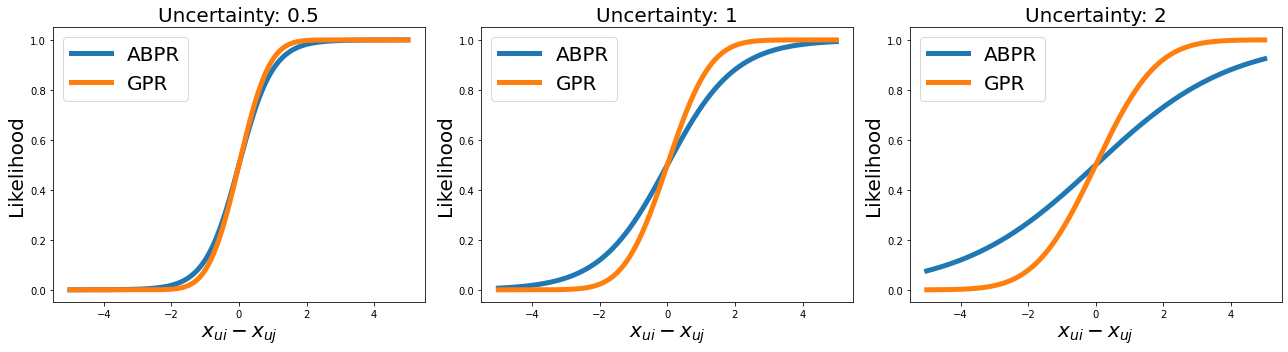

In [2]:
x = torch.linspace(-5, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, uncertainty in enumerate([0.5, 1, 2]):
    ax[idx].plot(x, adaptive_bpr(x, uncertainty), label='ABPR', linewidth=5)
    ax[idx].plot(x, uncertain(x, torch.tensor(uncertainty)), label='GPR', linewidth=5)
    ax[idx].set_title('Uncertainty: {}'.format(uncertainty), fontsize=20)
    ax[idx].set_xlabel(r'$x_{ui} - x_{uj}$', fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

Notice that both formulations are similar. In practice, the GPR is a less smooth (rougher) version of the adaptive BPR.

# Problem: The log scale

First, this is how the log-likelihood of $P(i >_u j)$ for different values of $\rho_{uij}$ looks like,

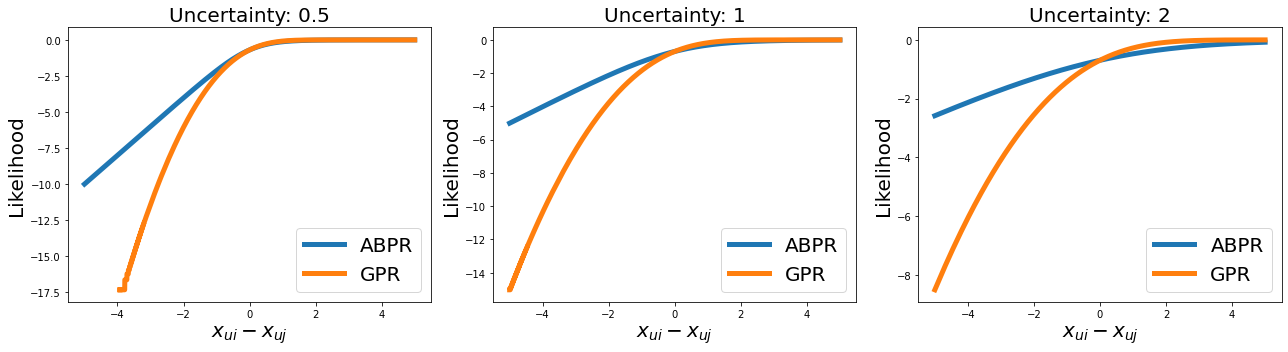

In [3]:
x = torch.linspace(-5, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, uncertainty in enumerate([0.5, 1, 2]):
    ax[idx].plot(x, adaptive_bpr(x, uncertainty).log(), label='ABPR', linewidth=5)
    ax[idx].plot(x, uncertain(x, torch.tensor(uncertainty)).log(), label='GPR', linewidth=5)
    ax[idx].set_title('Uncertainty: {}'.format(uncertainty), fontsize=20)
    ax[idx].set_xlabel(r'$x_{ui} - x_{uj}$', fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

Notice that for $\rho_{uij} = 0.5$ and $x_{uij} < -3$ the log-likelihood is already intractable. The problem is that, if the term $\frac{x_{uij}}{\rho_{uij}}$ (in the case of ABPR) or $\frac{\mu_{ui} - \mu_{uj}}{\rho_{uij}}$ (for GPR), is too small, then $P(i >_u j)$ goes to 0 its logarithm goes to $-\infty$. At 8-bit precision, $\log P(i >_u j) \rightarrow -\infty$ for $\frac{x_{uij}}{\rho_{uij}} < -88.7$ for ABPR and $\frac{\mu_{ui} - \mu_{uj}}{\rho_{uij}\sqrt{2}} < -3.9$ for GPR, as seen in the following cell.

In [4]:
def abpr(x):
    return x.sigmoid()

def gpr(x):
    return (0.5 * (1 + torch.erf((x))))

for func in [abpr, gpr]:
    x = torch.tensor(-1)
    while True:
        x = x - 0.01
        y = func(x)
        if y.log() == -float('inf'):
            print('Lower bound for {}: {}, occurred at y = {}. \n'.format(func, x, y))
            break

Lower bound for <function abpr at 0x7fdd9a2c4b80>: -88.73054504394531, occurred at y = 0.0. 

Lower bound for <function gpr at 0x7fdd97f87940>: -3.929997205734253, occurred at y = 0.0. 



The numerical instability for too small values is not the only problem regarding uncertainty in the loss scale. While maximizing the log-likelihood, the algorithm will give higher priority to incorrect classifications (negative > positive) then to already correct ones with small margin (when the positive relevace is just slightly higher than the negative). This does not happen is the normal (non-log) scale, as the following plot shows.

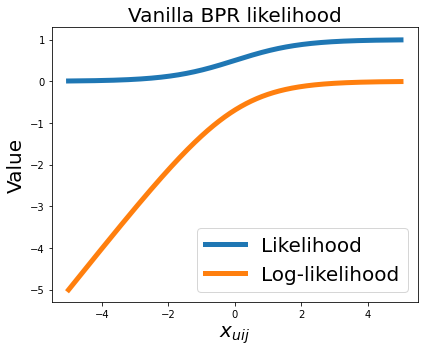

In [5]:
f, ax = plt.subplots(figsize=(6, 5))
x = torch.linspace(-5, 5, 10000)
y = adaptive_bpr(x, 1)
ax.plot(x, y, label='Likelihood', linewidth=5)
ax.plot(x, y.log(), label='Log-likelihood', linewidth=5)
ax.set_title('Vanilla BPR likelihood'.format(uncertainty), fontsize=20)
ax.set_xlabel(r'$x_{uij}$', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.legend(fontsize=20)
f.tight_layout()

Although this might be an advantage in terms of the pairwise ranking learning, it will lead the model to have poor uncertainty estimates for already correctly classified instances. Moreover, the set of recommendations for a user (top-K) consists of items that have been consider to be more relevant than other by the largest margins, meaning that the uncertainty estimates at top-K will be, most likely, very misleading.

# Modelling uncertainty

With the loss functions in hand, the question that remains is how to estimate the uncertainty parameters $\rho_{ui}$ or $\sigma^2_{ui}$ in the cases of adaptive BPR and gaussian BPR, respectively. We can enumerate a couple of options, as follows:

- The simplest approach to this problem is to consider that the uncertainty of an user-item pair to be a linear composition of an user and an item specific parameter. That is, $\rho_{ui} = \rho_u + \rho_i$.

- The linear approach, although, does not consider the interaction effect that might be present. That is, the fact that item uncertainty will varying depending on the user being considered. In order to consider such an effect, the uncertainty estimation task can be tackled as a collaborative filtering problem as well. For example, a matrix factorization can be used, and in this case, $\rho_{ui} = <p^\rho_u, q^\rho_i>$

- Finally, neural networks can be employed, in this case, both the interaction relevance $x_{ui}$ and ites uncertainty $\rho_{ui}$ may come from a shared latent space. That is, the user network is a function F: $p_u \times q_i \rightarrow x_{ui}, \rho_{ui}$

Is high negatives also certain? maybe uncertainty means that positive - negative is close to 0 or the mean is close to 0 (negatives and positives canceling).

Actually, the way we defined uncertainty is related to the errors commited by the model. Having a positive - negative close to 0 is an error, but even more explicit than that is the error of having positive - negative << 0.

It is possible to think of uncertainty also in terms of the probabilities $P(positive > negative)$. In this case, we could propose:

$$
P(positive > negative) = \begin{cases}
    0.5 \rightarrow \text{High uncertainty} \\
    0 \rightarrow \text{Low uncertainty} \\
    1 \rightarrow \text{Low uncertainty} \\
\end{cases}
$$

This would match Derek's uncertainty assumption. Also, we know that if X is the event positive > negative, then $X \sim Bern(p)$ and its variance is $p(1-p)$ that is maxed when $p=0.5$ and minized when $p=0$ or $1$. Nevertheless, with BPR, we model $p = P(positive > negative) = Sigmoid(positive - negative)$. Therefore, the uncertainty in this case would be modelled by the same parameter as the relevance, which don't add any information.

## Question: Is the uncertainty obtained by ABPR or GPR a theoretical consequence of their formulation?

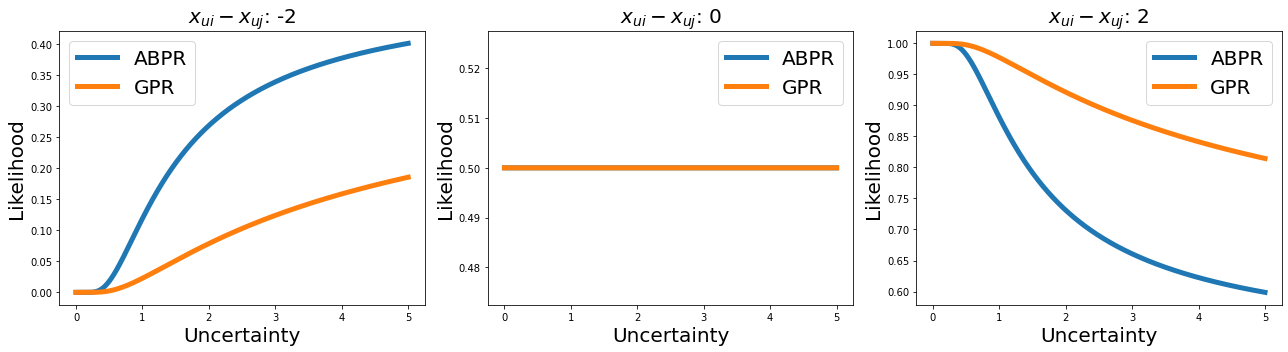

In [6]:
uncertainty = torch.linspace(0, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, x in enumerate([-2, 0, 2]):
    ax[idx].plot(uncertainty, adaptive_bpr(x, uncertainty), label='ABPR', linewidth=5)
    ax[idx].plot(uncertainty, uncertain(x, uncertainty), label='GPR', linewidth=5)
    ax[idx].set_xlabel('Uncertainty', fontsize=20)
    ax[idx].set_title(r'$x_{ui} - x_{uj}$' +': {}'.format(x), fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

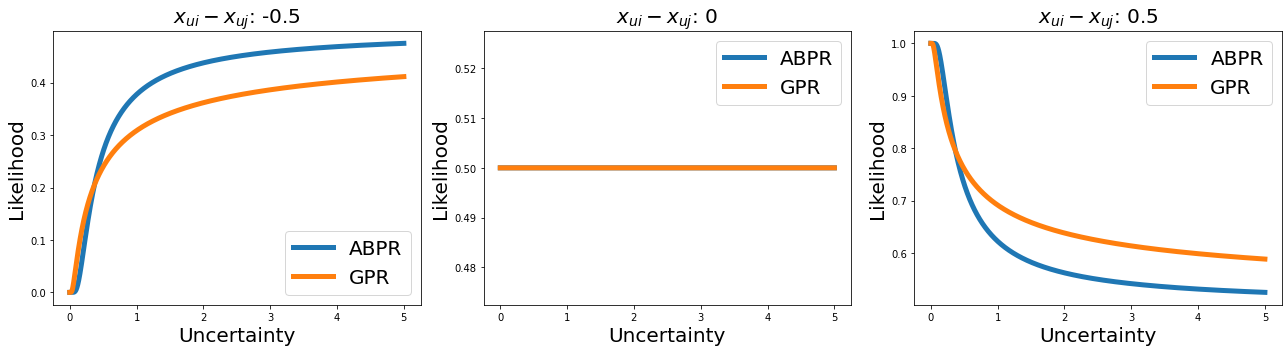

In [7]:
uncertainty = torch.linspace(0, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, x in enumerate([-0.5, 0, 0.5]):
    ax[idx].plot(uncertainty, adaptive_bpr(x, uncertainty), label='ABPR', linewidth=5)
    ax[idx].plot(uncertainty, uncertain(x, uncertainty), label='GPR', linewidth=5)
    ax[idx].set_xlabel('Uncertainty', fontsize=20)
    ax[idx].set_title(r'$x_{ui} - x_{uj}$' +': {}'.format(x), fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

# CAMF

One common way to approach an implicit feedback recommendation problem is to estimate the probability for each item ro be relevant to each user, namely $P_{ui}$. In this setup, the relationship for a user-item pair is assumed to have a Bernoulli distribution with probability of success $P_{ui}$. That is,

$$
X_{ui} \sim Bern(p_{ui})
$$

MF is one common technique employed to estimate these probabilities. In this case, $p_{ui} = <p_u, q_i>$, where $p_u$ and $q_i$ are the u-th user and i-th item latent factors, respectively.

Moving forward, we can model the distribution of $p_{ui}$, namely $P_{ui}$, instead of only giving a point estimate to it. One option is to assume $P_{ui} \sim Beta(a_{ui}, b_{ui})$. In this case, instead of estimating $p_{ui}$ directly, it is needed to estimate both distribution parameters. One option is using a neural network, which takes the user and item latent factors as input and outputs the distribution parameters, that is, the network is a function $f: p_u \times q_i \rightarrow a_{ui} \times b_{ui}$. GMF can be generalized for this problem, in this case,

$$
a_{ui} = Softplus(w_a (p_u \otimes q_i)) \qquad \text{and} \qquad b_{ui} = Softplus(w_b (p_u \otimes q_i))
$$

Where $\otimes$ denotes the hadamard product and $w_a, w_b$ are linear weights to be learned. To learn the parameters $\Theta = (p, q, w)$ from implicit feedback, we maximize the log-posterior distribution of the parameters. Starting with $\theta^0$, we do,

$$
f_{\theta_0} \rightarrow a_{ui}, b_{ui} \rightarrow P_{ui} \xrightarrow{Expectation} p_{ui} \rightarrow X_{ui}
$$